<a href="https://colab.research.google.com/github/JonathanLehner/Colab-collection/blob/master/pyrender_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# example from https://github.com/mmatl/pyrender/blob/master/examples/example.py
# tested with Python 3 and GPU environment on Google Colab

In [2]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl" #opengl seems to only work with TPU
!PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"
print(os.environ['PYOPENGL_PLATFORM']) 

egl


In [3]:
 # clone pyrender repo
%cd /content/
import os
from os.path import exists, join, basename

project_name = "pyrender"
if not exists(project_name):
  # clone and install
  !git clone -q https://github.com/mmatl/pyrender.git
  #requirements file gives the wrong pyglet
  #ERROR: pyrender 0.1.23 has requirement pyglet==1.4.0b1, but you'll have pyglet 1.4.0a1 which is incompatible.
  #!cd $project_name && pip install -q -r requirements.txt
  
import sys
sys.path.append(project_name)

/content


In [4]:
%cd /content/

/content


'!apt install libgl1-mesa-dri libegl1-mesa libgbm1\n!pip install wheel\n!pip install numpy\n!pip install Cython\n!git clone https://github.com/mcfletch/pyopengl.git\n%cd pyopengl\n!python setup.py develop\n%cd accelerate\n!python setup.py develop\n%cd /content/'

In [5]:
import OpenGL.GL as gl
print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 


None
None


In [6]:
# Install pyrender
!pip install pyrender

/content/pyrender/examples


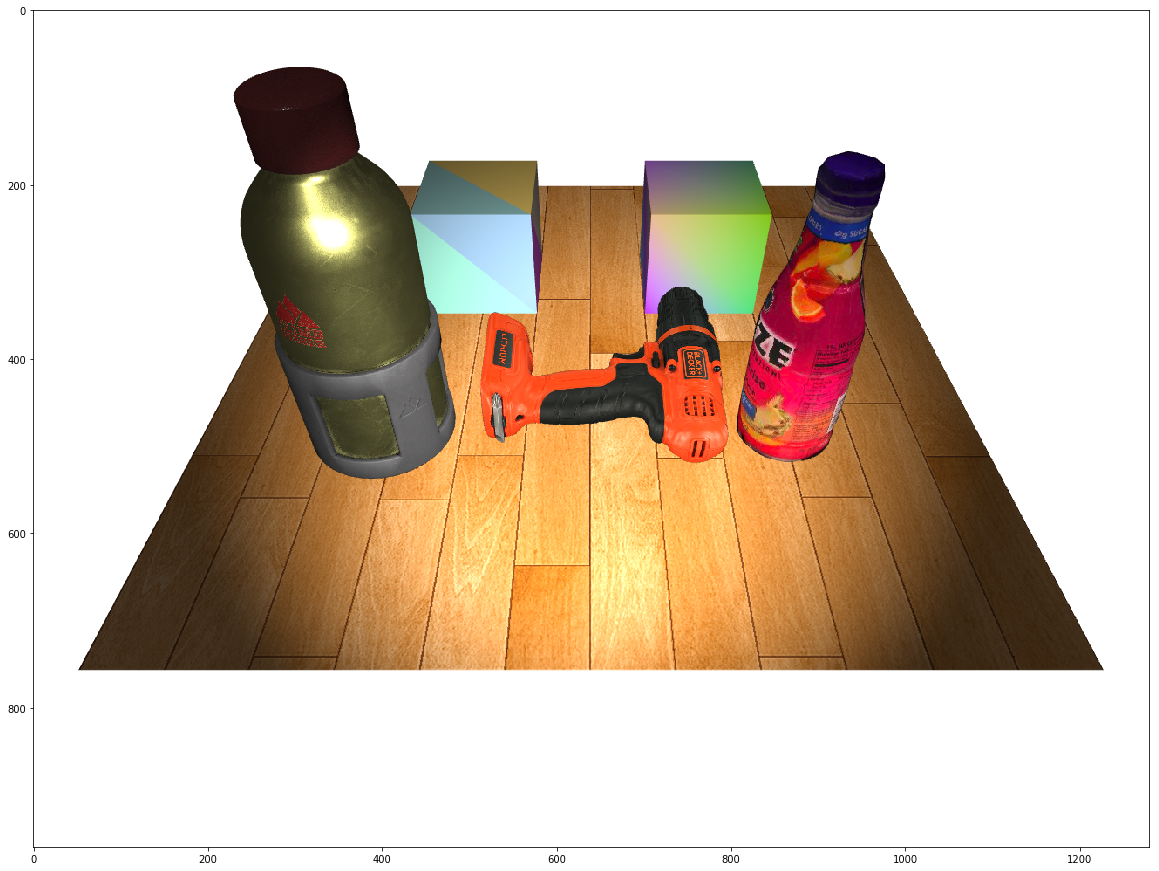

In [9]:
%cd /content/pyrender/examples/

"""Examples of using pyrender for viewing and offscreen rendering.
"""
# import pyglet
# pyglet.options['shadow_window'] = False
import os
import numpy as np
import trimesh

from pyrender import PerspectiveCamera,\
                     DirectionalLight, SpotLight, PointLight,\
                     MetallicRoughnessMaterial,\
                     Primitive, Mesh, Node, Scene,\
                     OffscreenRenderer

#==============================================================================
# Mesh creation
#==============================================================================

#------------------------------------------------------------------------------
# Creating textured meshes from trimeshes
#------------------------------------------------------------------------------

# Fuze trimesh
fuze_trimesh = trimesh.load('./models/fuze.obj')
fuze_mesh = Mesh.from_trimesh(fuze_trimesh)

# Drill trimesh
drill_trimesh = trimesh.load('./models/drill.obj')
drill_mesh = Mesh.from_trimesh(drill_trimesh)
drill_pose = np.eye(4)
drill_pose[0,3] = 0.1
drill_pose[2,3] = -np.min(drill_trimesh.vertices[:,2])

# Wood trimesh
wood_trimesh = trimesh.load('./models/wood.obj')
wood_mesh = Mesh.from_trimesh(wood_trimesh)

# Water bottle trimesh
bottle_gltf = trimesh.load('./models/WaterBottle.glb')
bottle_trimesh = bottle_gltf.geometry[list(bottle_gltf.geometry.keys())[0]]
bottle_mesh = Mesh.from_trimesh(bottle_trimesh)
bottle_pose = np.array([
    [1.0, 0.0,  0.0, 0.1],
    [0.0, 0.0, -1.0, -0.16],
    [0.0, 1.0,  0.0, 0.13],
    [0.0, 0.0,  0.0, 1.0],
])

#------------------------------------------------------------------------------
# Creating meshes with per-vertex colors
#------------------------------------------------------------------------------
boxv_trimesh = trimesh.creation.box(extents=0.1*np.ones(3))
boxv_vertex_colors = np.random.uniform(size=(boxv_trimesh.vertices.shape))
boxv_trimesh.visual.vertex_colors = boxv_vertex_colors
boxv_mesh = Mesh.from_trimesh(boxv_trimesh, smooth=False)

#------------------------------------------------------------------------------
# Creating meshes with per-face colors
#------------------------------------------------------------------------------
boxf_trimesh = trimesh.creation.box(extents=0.1*np.ones(3))
boxf_face_colors = np.random.uniform(size=boxf_trimesh.faces.shape)
boxf_trimesh.visual.face_colors = boxf_face_colors
boxf_mesh = Mesh.from_trimesh(boxf_trimesh, smooth=False)

#------------------------------------------------------------------------------
# Creating meshes from point clouds
#------------------------------------------------------------------------------
points = trimesh.creation.icosphere(radius=0.05).vertices
point_colors = np.random.uniform(size=points.shape)
points_mesh = Mesh.from_points(points, colors=point_colors)

#==============================================================================
# Light creation
#==============================================================================

direc_l = DirectionalLight(color=np.ones(3), intensity=1.0)
spot_l = SpotLight(color=np.ones(3), intensity=10.0,
                   innerConeAngle=np.pi/16, outerConeAngle=np.pi/6)
point_l = PointLight(color=np.ones(3), intensity=10.0)

#==============================================================================
# Camera creation
#==============================================================================

cam = PerspectiveCamera(yfov=(np.pi / 3.0))
cam_pose = np.array([
    [0.0,  -np.sqrt(2)/2, np.sqrt(2)/2, 0.5],
    [1.0, 0.0,           0.0,           0.0],
    [0.0,  np.sqrt(2)/2,  np.sqrt(2)/2, 0.4],
    [0.0,  0.0,           0.0,          1.0]
])

#==============================================================================
# Scene creation
#==============================================================================

scene = Scene(ambient_light=np.array([0.02, 0.02, 0.02, 1.0]))

#==============================================================================
# Adding objects to the scene
#==============================================================================

#------------------------------------------------------------------------------
# By manually creating nodes
#------------------------------------------------------------------------------
fuze_node = Node(mesh=fuze_mesh, translation=np.array([0.1, 0.15, -np.min(fuze_trimesh.vertices[:,2])]))
scene.add_node(fuze_node)
boxv_node = Node(mesh=boxv_mesh, translation=np.array([-0.1, 0.10, 0.05]))
scene.add_node(boxv_node)
boxf_node = Node(mesh=boxf_mesh, translation=np.array([-0.1, -0.10, 0.05]))
scene.add_node(boxf_node)

#------------------------------------------------------------------------------
# By using the add() utility function
#------------------------------------------------------------------------------
drill_node = scene.add(drill_mesh, pose=drill_pose)
bottle_node = scene.add(bottle_mesh, pose=bottle_pose)
wood_node = scene.add(wood_mesh)
direc_l_node = scene.add(direc_l, pose=cam_pose)
spot_l_node = scene.add(spot_l, pose=cam_pose)

#==============================================================================
# Using the viewer with a default camera
#==============================================================================

# needs a screen
# v = Viewer(scene, shadows=True)

#==============================================================================
# Using the viewer with a pre-specified camera
#==============================================================================

# needs a screen
# cam_node = scene.add(cam, pose=cam_pose)
# v = Viewer(scene, central_node=drill_node)

#==============================================================================
# Rendering offscreen from that camera
#==============================================================================

cam_node = scene.add(cam, pose=cam_pose)
r = OffscreenRenderer(viewport_width=640*2, viewport_height=480*2)
color, depth = r.render(scene)
r.delete()

import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(color)
plt.show()